<a href="https://colab.research.google.com/github/safdarjung/projects/blob/main/ocr_tableDetection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# installing the required github repo of objrct detection pretrained model

# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q timm

In [62]:
# importing required libraries

from huggingface_hub import hf_hub_download
from PIL import Image

In [63]:
from transformers import AutoModelForObjectDetection

# creating object detection model
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")


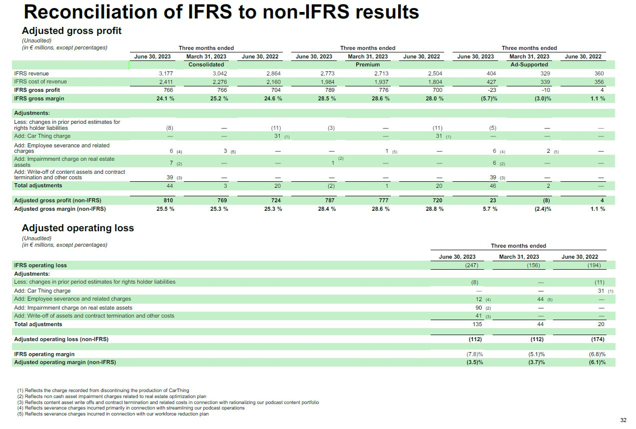

In [64]:
# loading and resizing the image

file_path = '/content/image00047.jpg'
image = Image.open(file_path)
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [65]:
from torchvision import transforms


# resizes an image to a maximum size while maintaining its aspect ratio.
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
#resizing, converting to a tensor, and normalizing. It then checks if a CUDA-enabled GPU is available and moves the model to the appropriate device.
detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [66]:
import torch
# Check if GPU is available
# Move the model to the chosen device (GPU or CPU)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")


In [67]:
#performs object detection using the model
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 540, 800])


In [68]:
import torch

# gradients are not necessary for backpropagation. Disabling them can improve performance slightly
with torch.no_grad():
  outputs = model(pixel_values)

outputs.logits.shape

torch.Size([1, 15, 3])

In [69]:
# convert bounding box formats and rescale bounding boxes to the original image size.

# Converting bounding boxes from center-coordinates and width-height format (cxcywh) to top-left corner and bottom-right corner format (xyxy).
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

#  Rescales bounding boxes predicted by the model to the original image size.
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
  #  calculates the maximum confidence score and its corresponding class index for each predicted bounding box.
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects



In [70]:
objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)


[{'label': 'table', 'score': 0.9998875856399536, 'bbox': [28.565837860107422, 92.91802978515625, 1225.5858154296875, 734.33349609375]}]


In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()
  # Loop through each detected table

    for det_table in det_tables:
        bbox = det_table['bbox']  # Get the bounding box coordinates

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

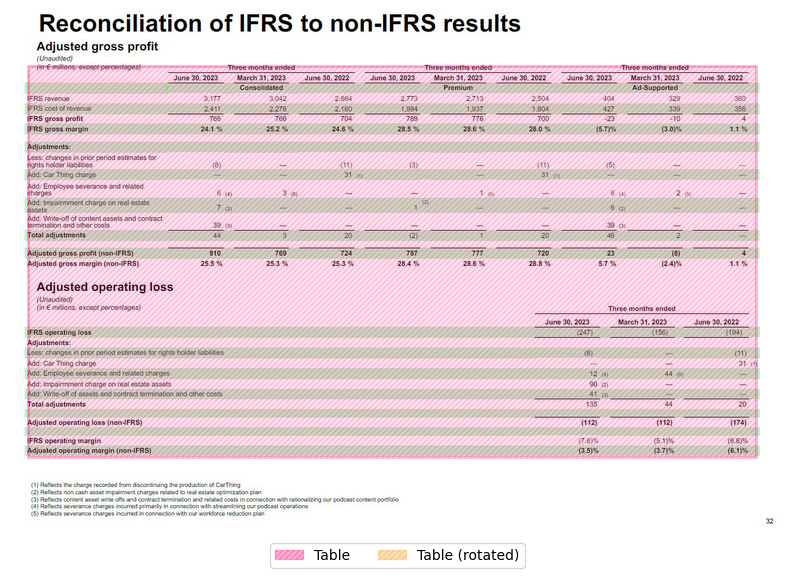

In [72]:
# visualise
fig = visualize_detected_tables(image, objects)

In [73]:
visualized_image = fig2img(fig)

In [74]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops



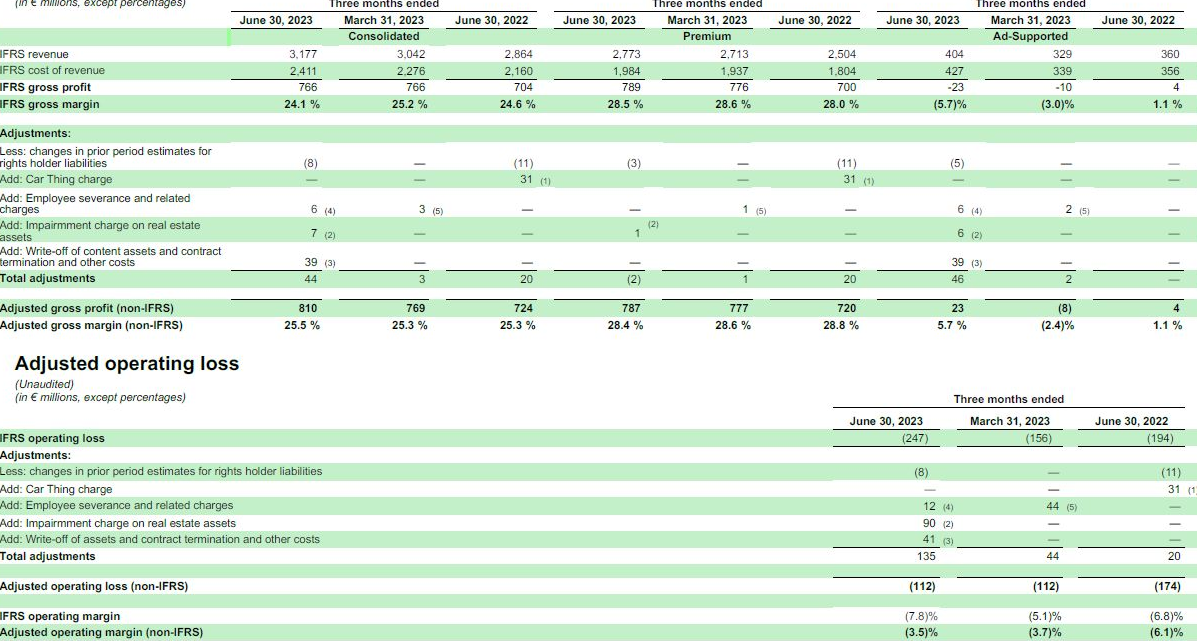

In [75]:
# Crops images of detected objects based on class labels and thresholds
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [76]:
# model for detecting the table structure / cells
from transformers import TableTransformerForObjectDetection

structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

In [77]:
structure_transform = transforms.Compose([
    MaxResize(1000),     #resizes the image to a maximum size of 1000 pixels on the larger dimension while maintaining the aspect ratio.
    transforms.ToTensor(),   #  converts the image from a PIL image format (like RGB) to a PyTorch tensor with normalized pixel values between 0 and 1.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # normalizes the pixel values in each color channel (Red, Green, Blue) based on the provided mean and standard deviation values
])

In [78]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)


torch.Size([1, 3, 536, 1000])


In [79]:
# gradients are not necessary for backpropagation. Disabling them can improve performance slightly

with torch.no_grad():
  outputs = structure_model(pixel_values)

In [80]:
# identify the cells strucure

structure_id2label = structure_model.config.id2label     # maps integer class IDs used by the model to human-readable labels
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table row', 'score': 0.8856334686279297, 'bbox': [0.26433974504470825, 404.1101379394531, 1191.732421875, 423.1848449707031]}, {'label': 'table row', 'score': 0.9802243709564209, 'bbox': [-0.04262968897819519, 194.8492889404297, 1191.5462646484375, 218.29046630859375]}, {'label': 'table column', 'score': 0.9997153878211975, 'bbox': [232.1928253173828, 3.6406664848327637, 334.5996398925781, 639.989013671875]}, {'label': 'table row', 'score': 0.9970792531967163, 'bbox': [0.08426052331924438, 493.99267578125, 1191.7926025390625, 511.4538269042969]}, {'label': 'table row', 'score': 0.9965922236442566, 'bbox': [0.047445595264434814, 59.49036407470703, 1191.70654296875, 77.03514099121094]}, {'label': 'table row', 'score': 0.9814666509628296, 'bbox': [0.005600720643997192, 235.7247314453125, 1191.5428466796875, 256.14410400390625]}, {'label': 'table row', 'score': 0.9702427387237549, 'bbox': [0.3320121467113495, 440.8423767089844, 1191.68798828125, 459.13800048828125]}, {'label': 

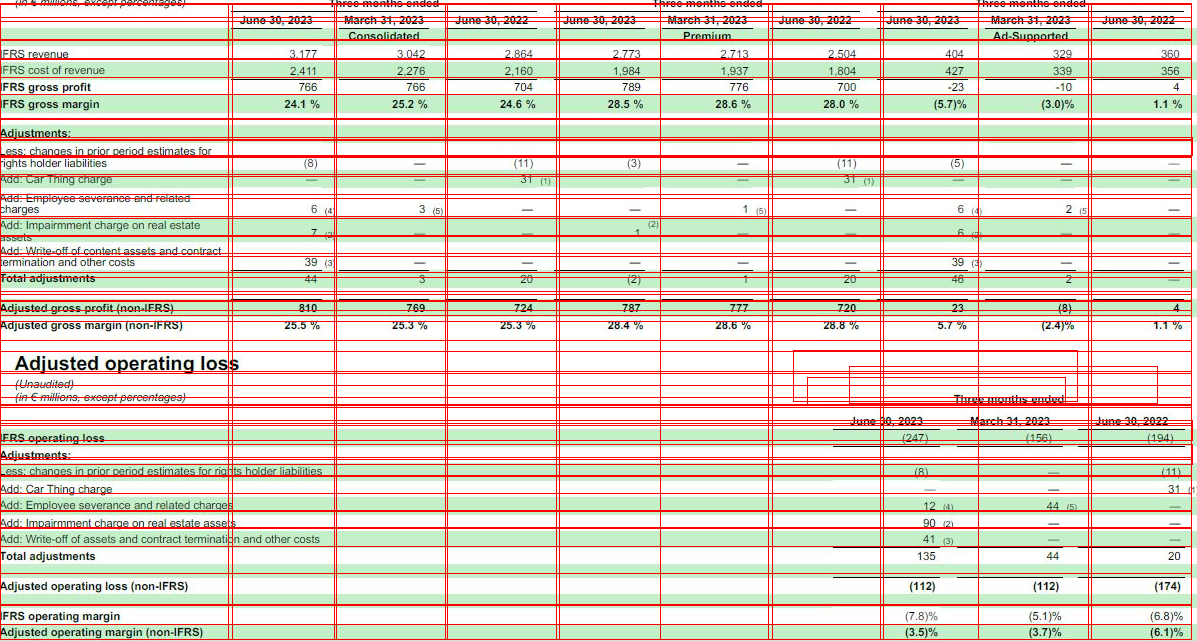

In [81]:
from PIL import ImageDraw


cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:    # iterating through the detected cells
    draw.rectangle(cell["bbox"], outline="red")   # extracts the bounding box coordinates for the current cell from the cell dictionary.

cropped_table_visualized

In [82]:
# visualize detected cells of a specific class on the cropped table image, highlighting their bounding boxes and displaying their labels and scores
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]     #Extracts the confidence score of the current cell.
        bbox = cell["bbox"]       #Extracts the bounding box coordinates of the current cell
        label = cell["label"]     #Extracts the predicted label (cell type) of the current cell.

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

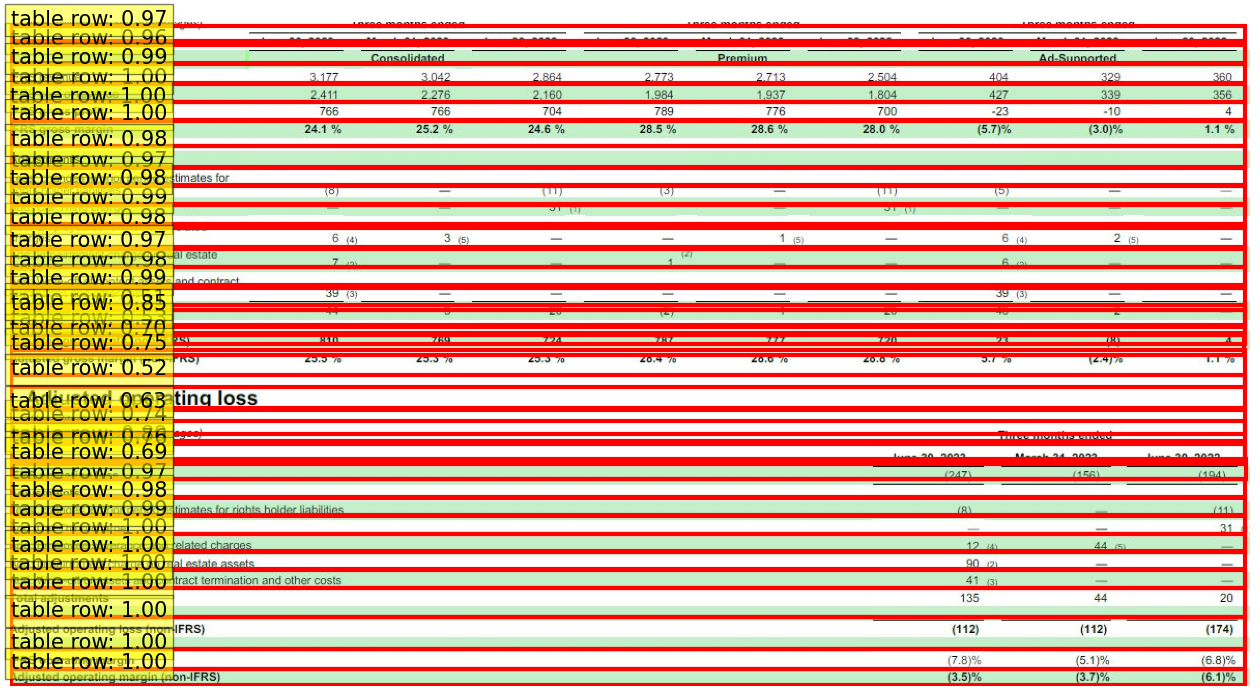

In [83]:
plot_results(cells, class_to_visualize="table row")

In [84]:
#analyzes the detected cells and attempts to organize them into a structured table format based on their positions
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [85]:
# for optical character recognition
!pip install easyocr

In [86]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

  0%|          | 0/35 [00:00<?, ?it/s]

Max number of columns: 10
['', '', '', '', '', '', '', '', '', '']
['consoncatco', 'Ad-Suonorcc', '', '', '', '', '', '', '', '']
['FRS revenue', '3U-E', '2.864', '504', '', '', '', '', '', '']
['FFRS ccst of revenue', '2276', '160', '1 464', '1.804', '356', '', '', '', '']
['IFRS gross profit', '766', '766', '704', '776', '700', '', '', '', '']
['FRS gross margin', '24.1 %', '25.2 %', '24.6 %', '28.5 %', '28.6 %', '28.0', '(5.719', '(3.019', '1.1 %']
['pdnustmenis', '', '', '', '', '', '', '', '', '']
['changes in prior period estmalcs', '', '', '', '', '', '', '', '', '']
['rignts holder liabilities', '', '', '', '', '', '', '', '', '']
['Ado; car Tning cnarge', '', '', '', '', '', '', '', '', '']
['Emp Oyec severancc and reaico chorges', '', '', '', '', '', '', '', '', '']
['Addz Imdarrmment charge on real estate', '', '', '', '', '', '', '', '', '']
['Add- Write off of conten- aSS806 and conac', '', '', '', '', '', '', '', '', '']
['crmination and Other costs', '', '', '', '', '', 

In [87]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)
